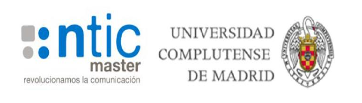

# NLP Deceitful Review Detection on e-Commerce and Social Media (2020)

This work is part of the final work to the <b>Master of Big Data and Business Analytics of the University Complutense of Madrid. 2019 - 2020.</b>



Authors: Marta Roig Atienza, Alejandra Lloret Calvo, Juan Pablo Guerrero Ortiz, Laura Débora Fernández Basquero, Ainhoa Rodrigo Bolea, Cristian Fernando Rodríguez Saldarriaga


# H2O
Final Release

<b> Libraries </b> 

In [3]:
# Varios
# ------------------------------------------------------------------------------
from collections import defaultdict
import os.path
import logging
from sinfo import sinfo
import re
import string
import math

# Tratamiento de textos
# ------------------------------------------------------------------------------
from scipy import sparse
import nltk
from nltk.tokenize import word_tokenize, sent_tokenize

# Tratamiento de datos
# ------------------------------------------------------------------------------
import pandas as pd
import numpy as np

# Preprocesado y modelado
# ------------------------------------------------------------------------------
# ----------- gensim ----------
import gensim
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.utils import simple_preprocess
from gensim.models import Word2Vec
from gensim.sklearn_api import TfIdfTransformer
from gensim.test.utils import common_corpus, common_dictionary
from gensim import models, corpora, matutils

# ----------- sklearn ----------
import joblib
from sklearn import model_selection, datasets
from sklearn.externals import joblib
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# Gráficos
# ------------------------------------------------------------------------------
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.ticker as ticker
import seaborn as sns
import cufflinks
import plotly.express as px
from plotly.offline import iplot
cufflinks.go_offline()
cufflinks.set_config_file(world_readable=True, theme='pearl')

# Configuración warnings
# ------------------------------------------------------------------------------
import warnings
warnings.filterwarnings("ignore")

## Definition Functions

### Loading Data

In [4]:
def read_data(filename, sep=','):
    """
        filename: path dataSet
        sep: separator text     

        return: data
    """
    data = pd.read_csv(filename, sep=sep, encoding='utf-8')
    return data


def parse_label(label):
    """
        label: convert parse label to fake: 1 and real: 0    

        return: label in 1 and 0
    """
    if label == 'true':
        return 1  # 'real or true'
    else:
        return 0  # 'fake'

def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text, language='english'):
        for word in nltk.word_tokenize(sent, language='english'):
            if len(word) < 2:
                continue
            tokens.append(word)
    return tokens

### Load embedding model

In [5]:
def load_embedding_model(type_embedding, file_location):
    """
        Load your favourite embedding pre-trained model and it will be used to vectorize the words 
        Do not forget that you could choose the lenght vector of the pre-trained model. Your selection could be 
        between the next two options and vectors lengths:

         - Glove Files: 
            glove.6B.50d.txt
            glove.6B.100d.txt
            glove.6B.200d.txt
            glove.6B.300d.txt

        - word2vec Files:
            GoogleNews-vectors-negative300.bin.gz
            firebase-vectors-1000d.bin

        Parameters:
        type_embedding: Choose between 1 or 2 to apply load file function, correctly.
            1: Word2vec Files
            2: Glove Files

        Return embedding model
    """

    # Loading Embedding Model -> Word2Vec
    if type_embedding == 1:
        print("Loading Embedding Model")
        # Load the input-hidden weight matrix from the original C word2vec-tool format.
        w2v_model = KeyedVectors.load_word2vec_format(
            str(file_location), binary=True)
        # If replace is set, forget the original vectors and only keep the normalized ones = saves lots of memory!
        w2v_model.init_sims(replace=True)
        
        # Validate the length of the vocabulary
        if len(w2v_model.vocab) != 0:
            print("Vocabulary vectors loaded!")
            # return embedding model
            print(w2v_model)
            return w2v_model
        else:
            return print('Cannot create model!')

    # Loading Embedding Model -> Glove
    elif type_embedding == 2:
        print("Loading Embedding Model")
        # Paths
        glove_input_file = str(file_location)
        glove_output_file = (glove_input_file + '.word2vec')
        # Convert `glove_input_file` in GloVe format to word2vec format and write it to `word2vec_output_file`.
        glove2word2vec(glove_input_file, glove_output_file)
        
        # Validation exist file
        if os.path.isfile(glove_output_file):
            print("Vocabulary vectors loaded!")
            # Load the input-hidden weight matrix from the original C word2vec-tool format.
            glove_model = KeyedVectors.load_word2vec_format(
                glove_output_file, binary=False)
            # If replace is set, forget the original vectors and only keep the normalized ones...
            glove_model.init_sims(replace=True)
            # return embedding model
            print(glove_model)
            return glove_model
        else:
            return print('File not exist "word2vec_output_file"...cannot create model!')

### Averaging Embedding Models 

In [6]:
def word_averaging(embedding_model, words):
    """
         embedding_model: embedding pre-trained model 
         words:     

         return: mean
     """
    all_words, mean = set(), []
    
    for word in words:
        if isinstance(word, np.ndarray):
            mean.append(word)
        elif word in embedding_model.vocab:
            mean.append(embedding_model.syn0norm[embedding_model.vocab[word].index])
            all_words.add(embedding_model.vocab[word].index)

    if not mean:
        logging.warning("cannot compute similarity with no input %s", words)
        # FIXME: remove these examples in pre-processing
        return np.zeros(embedding_model.vector_size,)

    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    
    return mean

def  word_averaging_list(embedding_model, text_list):
    """
         embedding_model: embedding pre-trained model
         text_list:     

         return: The array formed by stacking the given arrays, will be at least 2-D.
     """
    return np.vstack([word_averaging(embedding_model, post) for post in text_list])

### Feature vector

In [7]:
def feature_vector(type_vect, x_train, x_test, text_review, set_columns =[], 
                   embedding_model = 0, ngram_range =(2, 2)):
    """
        type_vect: creation vector type
            1: TF-IDF
            2: CountVectorizer
            3: N-Grams
            4: Word2vec
            5: Glove
        x_train, x_test — samples
        text_review: text to be converted into a set of numbers (vectorization)
        set_columns: different columns to be added to the model
        embedding_model: embedding pre-trained model
        range_ngram: represent all combinations of words of length n in your text (bigram, trigram, four-gram)
       
        return vectorized representation of each type and vocabulary
    """
    # Create vectorizer with a proper parameters choice
    # Fit the vectorizer on the train set
    # Transform the train, test sets and return the result

    # TF-IDF
    if type_vect == 1:
        tfidf_vect = TfidfVectorizer(max_features = 300)
        # Fit
        tfidf_vect_fit = tfidf_vect.fit(x_train[text_review])
        # Transform
        tfidf_train = tfidf_vect_fit.transform(x_train[text_review])
        tfidf_test = tfidf_vect_fit.transform(x_test[text_review])

        # Validation add more features
        if len(set_columns) == 0:
            x_train_tfidf = tfidf_train
            x_test_tfidf = tfidf_test
        else:
            # csr_matrix -> Compressed Sparse Row matrix
            csr_mxTrain = sparse.csr_matrix(x_train[set_columns])
            csr_mxTest = sparse.csr_matrix(x_test[set_columns])
            # sparse.hstack -> Stack sparse matrices horizontally (column wise)
            x_train_tfidf = sparse.hstack([csr_mxTrain, tfidf_train], format="csr")
            x_test_tfidf = sparse.hstack([csr_mxTest, tfidf_test], format="csr")

        return x_train_tfidf, x_test_tfidf

    # CountVectorizer
    elif type_vect == 2:
        count_vect = CountVectorizer(max_features = 300)
        # Fit
        countVect_fit = count_vect.fit(x_train[text_review])
        # Transform
        countVect_train = countVect_fit.transform(x_train[text_review])
        countVect_test = countVect_fit.transform(x_test[text_review])

        # Validation add more features
        if len(set_columns) == 0:
            x_train_countVect = countVect_train
            x_test_countVect = countVect_test

        else:
            # csr_matrix -> Compressed Sparse Row matrix
            csr_mxTrain = sparse.csr_matrix(x_train[set_columns])
            csr_mxTest = sparse.csr_matrix(x_test[set_columns])
            # sparse.hstack -> Stack sparse matrices horizontally (column wise)
            x_train_countVect = sparse.hstack([csr_mxTrain, countVect_train], format="csr")
            x_test_countVect = sparse.hstack([csr_mxTest, countVect_test], format="csr")

        return x_train_countVect, x_test_countVect

    # N-Grams
    elif type_vect == 3:
        ngram_vect = CountVectorizer(ngram_range=ngram_range, max_features = 300)
        # Fit
        ngram_vect_fit = ngram_vect.fit(x_train[text_review])
        # Transform
        ngram_train = ngram_vect_fit.transform(x_train[text_review])
        ngram_test = ngram_vect_fit.transform(x_test[text_review])

        # Validation add more features
        if len(set_columns) == 0:
            x_train_ngram = ngram_train
            x_test_ngram = ngram_test
        else:
            # csr_matrix -> Compressed Sparse Row matrix
            csr_mxTrain = sparse.csr_matrix(x_train[set_columns])
            csr_mxTest = sparse.csr_matrix(x_test[set_columns])
            # sparse.hstack -> Stack sparse matrices horizontally (column wise)
            x_train_ngram = sparse.hstack([csr_mxTrain, ngram_train], format="csr")
            x_test_ngram = sparse.hstack([csr_mxTest, ngram_test], format="csr")

        return x_train_ngram, x_test_ngram
    
    # Word2vec
    elif type_vect == 4:
    
        # Apply word_averaging_list and convert to Compressed Sparse Row matrix
        x_train_word_average = word_averaging_list(embedding_model, x_train[text_review])
        x_train_word_average = sparse.csr_matrix(x_train_word_average)
        x_test_word_average = word_averaging_list(embedding_model, x_test[text_review])
        x_test_word_average = sparse.csr_matrix(x_test_word_average)

        # Validation add more features
        if len(set_columns) == 0:
            x_train_word2vec = x_train_word_average
            x_test_word2vec = x_test_word_average
        else:
            # Compressed Sparse Row matrix
            csr_mxTrain = sparse.csr_matrix(x_train[set_columns])
            csr_mxTest = sparse.csr_matrix(x_test[set_columns])
            # Stack sparse matrices horizontally (column wise)
            x_train_word2vec = sparse.hstack([csr_mxTrain, x_train_word_average], format="csr")
            x_test_word2vec = sparse.hstack([csr_mxTest, x_test_word_average], format="csr")

        return x_train_word2vec, x_test_word2vec

    # Glove
    elif type_vect == 5:
        # Apply word_averaging_list and convert to Compressed Sparse Row matrix
        x_train_word_average = word_averaging_list(embedding_model, x_train[text_review])
        x_train_word_average = sparse.csr_matrix(x_train_word_average)

        x_test_word_average = word_averaging_list(embedding_model, x_test[text_review])
        x_test_word_average = sparse.csr_matrix(x_test_word_average)

        # Validation add more features
        if len(set_columns) == 0:
            x_train_glove = x_train_word_average
            x_test_glove = x_test_word_average
        else:
            # Compressed Sparse Row matrix
            csr_mxTrain = sparse.csr_matrix(x_train[set_columns])
            csr_mxTest = sparse.csr_matrix(x_test[set_columns])
            # Stack sparse matrices horizontally (column wise)
            x_train_glove = sparse.hstack([csr_mxTrain, x_train_word_average], format="csr")
            x_test_glove = sparse.hstack([csr_mxTest, x_test_word_average], format="csr")

        return x_train_glove, x_test_glove

## Read Data

In [11]:
#Train Data
x_train = read_data('../../x_train_v2.csv', sep=',')
y_train = read_data('../../y_train.csv', sep=',')

# Test data
x_test = read_data('../../x_test_v2.csv')
y_test = read_data('../../y_test.csv')

# Parse label to true = 0 and fake = 1
y_train['LABEL'] = y_train['LABEL'].apply(lambda x: parse_label(x))
y_test['LABEL'] = y_test['LABEL'].apply(lambda x: parse_label(x))

#Tokenize the text column to get the new column 'tokenized_text'
x_train['tokenized_text'] = x_train.apply(lambda r: tokenize_text(r['REVIEW_TEXT']), axis=1).values
x_test['tokenized_text'] = x_test.apply(lambda r: tokenize_text(r['REVIEW_TEXT']), axis=1).values

print(len(x_train))
print(len(x_test))
x_test[5:30:5]

15750
5250


,DOC_ID,RATING,VERIFIED_PURCHASE,PRODUCT_CATEGORY,PRODUCT_ID,PRODUCT_TITLE,REVIEW_TITLE,REVIEW_TEXT,ORIGINAL_REVIEW,ORIGINAL_REVIEW_TITLE,...,word_count,PUNCT,stopwords,CommonWords_count,Bigrams_count,Trigrams_count,fullReview,DL_CLASSIFICATION_bin,DL_CLASSIFICATION_con,tokenized_text
5,8575,5,0,Grocery,B007P4MADE,mehr saffron premium spanish saffron thread gr...,saffron rice,saffron rice people would call recipe persian ...,Saffron rice is what most people would call re...,Saffron Rice,...,30,1.7,38.8,4,0,0,"mehr saffron, premium spanish saffron threads ...",0,0.091794,"[saffron, rice, people, would, call, recipe, p..."
10,9668,5,1,Jewelry,B00E0IV9P8,vintage angel wing men cross pendant adjustabl...,love it,wear cross pendant every day even shower look ...,I wear this cross pendant every day Even in sh...,Love it!,...,32,2.1,52.2,5,0,0,vintage angel wing mens cross pendant adjustab...,1,0.569335,"[wear, cross, pendant, every, day, even, showe..."
15,2722,4,0,Automotive,B0012WHBSO,viair heavy duty portable compressor,work well,own cheap compressor get walmart one much good...,I've owned a few cheap compressors that I got ...,Works well,...,23,2.7,41.0,5,0,0,viair 00073 70p heavy duty portable compressor...,0,0.453202,"[own, cheap, compressor, get, walmart, one, mu..."
20,17466,5,1,Office Products,B00HNCNT0G,chalk ink marker neon set pack best chalk ink ...,great marker,first let warn instruction marker when get exc...,"First, let me warn you about the instructions ...",Great marker,...,147,7.2,46.3,17,1,0,"chalk ink markers - neon set (8-pack), best ch...",1,0.621617,"[first, let, warn, instruction, marker, when, ..."
25,6852,5,1,Electronics,B00ET3QQUW,samsungcompatible incredisonic vue series acti...,excellent value rechargeable,love fact rechargeable time watch battery add ...,"LOVE the fact they are rechargeable, over time...",Excellent value and rechargeable!,...,20,3.4,39.5,5,1,0,samsung-compatible incredisonic vue series act...,1,0.611572,"[love, fact, rechargeable, time, watch, batter..."


## Vectorization
Train vectorizers on training set and use that to transform test set.

### TF-IDF

In [12]:
textReview_tfidf = 'REVIEW_TEXT'
columnsDataSet_tfidf = ['RATING', 'VERIFIED_PURCHASE', 'polarity', 'subjectivity',
                        'word_count', 'PUNCT', 'stopwords', 'Bigrams_count', 'Trigrams_count']

vect_train_tfidf, vect_test_tfidf = feature_vector(1, x_train, x_test, textReview_tfidf,
                                                   columnsDataSet_tfidf)

vect_train_tfidf

<15750x309 sparse matrix of type '<class 'numpy.float64'>'
	with 352054 stored elements in Compressed Sparse Row format>

### CountVectorizer

In [13]:
textReview_countVect = 'REVIEW_TEXT'
columnsDataSet_countVect = ['RATING', 'VERIFIED_PURCHASE', 'polarity', 'subjectivity',
                            'word_count', 'PUNCT', 'stopwords', 'CommonWords_count', 'Bigrams_count',
                            'Trigrams_count']

vect_train_countVect, vect_test_countVect = feature_vector(2, x_train, x_test,
                                                           textReview_countVect, columnsDataSet_countVect)
vect_train_countVect

<15750x310 sparse matrix of type '<class 'numpy.float64'>'
	with 367353 stored elements in Compressed Sparse Row format>

### N-GRAMS

In [ ]:
textReview_ngram = 'REVIEW_TEXT'
columnsDataSet_ngram = ['RATING', 'VERIFIED_PURCHASE', 'polarity', 'subjectivity',
                        'word_count', 'PUNCT', 'stopwords', 'Bigrams_count', 'Trigrams_count']
ngram_range = (2, 2)

vect_train_ngrams, vect_test_ngrams = feature_vector(3, x_train, x_test,
                                                     textReview_ngram, columnsDataSet_ngram, ngram_range)
vect_train_ngrams

### Word2Vec

In [ ]:
# Load the embedded model
w2v_model = load_embedding_model(1, "../modelos/Word2Vec/GoogleNews-vectors-negative300.bin")

In [ ]:
textReview_word2vec = 'tokenized_text'
columnsDataSet_word2vec = ['RATING', 'VERIFIED_PURCHASE', 'polarity', 'subjectivity',
                           'word_count', 'PUNCT', 'stopwords', 'Bigrams_count', 'Trigrams_count']

vect_train_word2vec, vect_test_word2vec = feature_vector(4, x_train, x_test,
                                                     textReview_word2vec, columnsDataSet_word2vec, w2v_model)

vect_train_word2vec

### Glove

In [ ]:
# Load the embedded model
glove_model = load_embedding_model(2, "../../modelos/glove.6B/glove.6B.100d.txt")

In [ ]:
textReview_glove = 'tokenized_text'

columnsDataSet_glove = ['RATING', 'VERIFIED_PURCHASE', 'polarity', 'subjectivity',
                        'word_count', 'PUNCT', 'stopwords', 'CommonWords_count', 'Bigrams_count',
                        'Trigrams_count']
vect_train_glove, vect_test_glove = feature_vector(5, x_train, x_test,
                                                     textReview_glove, columnsDataSet_glove, glove_model)
vect_train_glove

## H2OAutoML

In [77]:
import h2o
from h2o.automl import H2OAutoML
from h2o.estimators.word2vec import H2OWord2vecEstimator
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.estimators.xgboost import H2OXGBoostEstimator

In [78]:
# Initialize
h2o.init(max_mem_size="8G")

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "1.8.0_152-release"; OpenJDK Runtime Environment (build 1.8.0_152-release-1056-b12); OpenJDK 64-Bit Server VM (build 25.152-b12, mixed mode)
  Starting server from /Users/Cristian/opt/anaconda3/envs/tf/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/_x/54jqsbr57132xxtkfcy8r54m0000gn/T/tmpchviu6qq
  JVM stdout: /var/folders/_x/54jqsbr57132xxtkfcy8r54m0000gn/T/tmpchviu6qq/h2o_Cristian_started_from_python.out
  JVM stderr: /var/folders/_x/54jqsbr57132xxtkfcy8r54m0000gn/T/tmpchviu6qq/h2o_Cristian_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,Europe/Madrid
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.1.2
H2O_cluster_version_age:,11 days
H2O_cluster_name:,H2O_from_python_Cristian_299v5j
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,7.111 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"accepting new members, healthy"


### Loading Vector to H2O 

In [73]:
# Type the best vector model and parameters
best_vect_train = vect_train_countVect
best_vect_test = vect_test_countVect

# Transform to object H2O
h2o_y_train = h2o.H2OFrame(y_train)
h2o_y_test = h2o.H2OFrame(y_test)

h2o_vect_train = h2o.H2OFrame(best_vect_train)
h2o_vect_test = h2o.H2OFrame(best_vect_test)

h2o_vect_train

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35,C36,C37,C38,C39,C40,C41,C42,C43,C44,C45,C46,C47,C48,C49,C50,C51,C52,C53,C54,C55,C56,C57,C58,C59,C60,C61,C62,C63,C64,C65,C66,C67,C68,C69,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79,C80,C81,C82,C83,C84,C85,C86,C87,C88,C89,C90,C91,C92,C93,C94,C95,C96,C97,C98,C99,C100,C101,C102,C103,C104,C105,C106,C107,C108,C109,C110,C111,C112,C113,C114,C115,C116,C117,C118,C119,C120,C121,C122,C123,C124,C125,C126,C127,C128,C129,C130,C131,C132,C133,C134,C135,C136,C137,C138,C139,C140,C141,C142,C143,C144,C145,C146,C147,C148,C149,C150,C151,C152,C153,C154,C155,C156,C157,C158,C159,C160,C161,C162,C163,C164,C165,C166,C167,C168,C169,C170,C171,C172,C173,C174,C175,C176,C177,C178,C179,C180,C181,C182,C183,C184,C185,C186,C187,C188,C189,C190,C191,C192,C193,C194,C195,C196,C197,C198,C199,C200,C201,C202,C203,C204,C205,C206,C207,C208,C209,C210,C211,C212,C213,C214,C215,C216,C217,C218,C219,C220,C221,C222,C223,C224,C225,C226,C227,C228,C229,C230,C231,C232,C233,C234,C235,C236,C237,C238,C239,C240,C241,C242,C243,C244,C245,C246,C247,C248,C249,C250,C251,C252,C253,C254,C255,C256,C257,C258,C259,C260,C261,C262,C263,C264,C265,C266,C267,C268,C269,C270,C271,C272,C273,C274,C275,C276,C277,C278,C279,C280,C281,C282,C283,C284,C285,C286,C287,C288,C289,C290,C291,C292,C293,C294,C295,C296,C297,C298,C299,C300,C301,C302,C303,C304,C305,C306,C307,C308,C309,C310
5,0,0.261458,0.552083,25,3.3,30.6,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,1,0.161667,0.559167,29,2.7,37,4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,1,0.583333,0.777778,18,2.8,44.1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0.0788889,0.447778,27,2.6,44.2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

### Training data H2O


In [17]:
# Target variable -> 'LABEL' -> for binary classification, response should be a factor
h2o_y_train['LABEL'] = h2o_y_train['LABEL'].asfactor()
h2o_y_test['LABEL'] = h2o_y_test['LABEL'].asfactor()

# Union of the target variable to the vector
h2o_train = h2o_y_train.cbind(h2o_vect_train)
h2o_test = h2o_y_test.cbind(h2o_vect_test)

# Identify the response and set of predictors
predictors = h2o_train.names
response = 'LABEL'

# View h2o_train
h2o_train

LABEL,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,C11,C12,C13,C14,C15,C16,C17,C18,C19,C20,C21,C22,C23,C24,C25,C26,C27,C28,C29,C30,C31,C32,C33,C34,C35,C36,C37,C38,C39,C40,C41,C42,C43,C44,C45,C46,C47,C48,C49,C50,C51,C52,C53,C54,C55,C56,C57,C58,C59,C60,C61,C62,C63,C64,C65,C66,C67,C68,C69,C70,C71,C72,C73,C74,C75,C76,C77,C78,C79,C80,C81,C82,C83,C84,C85,C86,C87,C88,C89,C90,C91,C92,C93,C94,C95,C96,C97,C98,C99,C100,C101,C102,C103,C104,C105,C106,C107,C108,C109,C110,C111,C112,C113,C114,C115,C116,C117,C118,C119,C120,C121,C122,C123,C124,C125,C126,C127,C128,C129,C130,C131,C132,C133,C134,C135,C136,C137,C138,C139,C140,C141,C142,C143,C144,C145,C146,C147,C148,C149,C150,C151,C152,C153,C154,C155,C156,C157,C158,C159,C160,C161,C162,C163,C164,C165,C166,C167,C168,C169,C170,C171,C172,C173,C174,C175,C176,C177,C178,C179,C180,C181,C182,C183,C184,C185,C186,C187,C188,C189,C190,C191,C192,C193,C194,C195,C196,C197,C198,C199,C200,C201,C202,C203,C204,C205,C206,C207,C208,C209,C210,C211,C212,C213,C214,C215,C216,C217,C218,C219,C220,C221,C222,C223,C224,C225,C226,C227,C228,C229,C230,C231,C232,C233,C234,C235,C236,C237,C238,C239,C240,C241,C242,C243,C244,C245,C246,C247,C248,C249,C250,C251,C252,C253,C254,C255,C256,C257,C258,C259,C260,C261,C262,C263,C264,C265,C266,C267,C268,C269,C270,C271,C272,C273,C274,C275,C276,C277,C278,C279,C280,C281,C282,C283,C284,C285,C286,C287,C288,C289,C290,C291,C292,C293,C294,C295,C296,C297,C298,C299,C300,C301,C302,C303,C304,C305,C306,C307,C308,C309,C310
0,5,0,0.261458,0.552083,25,3.3,30.6,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,5,1,0.161667,0.559167,29,2.7,37,4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,5,1,0.583333,0.777778,18,2.8,44.1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,5,0,0.0788889,0.447778,27,2.6,44.2,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0

__Automatic Machine Learning__

The Automatic Machine Learning (AutoML) function automates the supervised machine learning model training process.

    The current version of AutoML trains and cross-validates 
        - a Random Forest (DRF), 
        - an Extremely-Randomized Forest (DRF/XRT),
        - a random grid of Generalized Linear Models (GLM)
        - a random grid of XGBoost (XGBoost))(ONLY For Mac or Linux),
        - a random grid of Gradient Boosting Machines (GBM), 
        - a random grid of Deep Neural Nets (DeepLearning), 
        - and 2 Stacked Ensembles, one of all the models, and one of only the best models of each kind.

### Parametrization AutoML Method

In [18]:
# Define parameters
# Number of folds for k-fold cross-validation
nFolds=5
# Maximum time that the AutoML process will run
maxRuntimeSec=600 
# Maximum number of models to build in an AutoML run
maxModels=20
# Metric to use for early stopping
stoppingMetric='auc'
# Seed for reproducibility
seed=825
# Name to identify an AutoML project
projectName='AutoML_H2O_NLP_AmazonReview'
# List of character strings naming the algorithms to skip during the model-building phase
excludeAlgos=["StackedEnsemble"] # AutoML: XGBoost is not available; skipping it.
# sort_metric: Metric to sort the leaderboard by
sortMetric='auc'
# Verbosity of the backend messages printed during training.
verbosity='warn'

### AutoML 

In [19]:
# AutoML
autoML = H2OAutoML(nfolds=nFolds, max_runtime_secs=maxRuntimeSec, max_models=maxModels, 
                   stopping_metric=stoppingMetric, seed=seed, project_name=projectName, 
                   exclude_algos=excludeAlgos, sort_metric=sortMetric, verbosity=verbosity)

# Train AutoML
autoML.train(x=predictors, y=response, training_frame=h2o_train, validation_frame=h2o_test)

AutoML progress: |
11:10:18.104: User specified a validation frame with cross-validation still enabled. Please note that the models will still be validated using cross-validation only, the validation frame will be used to provide purely informative validation metrics on the trained models.

████████████████████████████████████████████████████████| 100%


### LeaderBoard Results

In [20]:
# Print Leaderboard (ranked by xval metrics)
leaderboard = autoML.leaderboard
print(leaderboard)

model_id,auc,logloss,aucpr,mean_per_class_error,rmse,mse
XGBoost_grid__1_AutoML_20200915_111018_model_3,0.868807,0.445649,0.842654,0.194984,0.375898,0.141299
XGBoost_grid__1_AutoML_20200915_111018_model_1,0.866613,0.448169,0.83652,0.193397,0.377295,0.142351
GBM_grid__1_AutoML_20200915_111018_model_1,0.866109,0.453821,0.838035,0.195365,0.379348,0.143905
XGBoost_3_AutoML_20200915_111018,0.864438,0.450772,0.834703,0.195873,0.378399,0.143186
XGBoost_2_AutoML_20200915_111018,0.862677,0.456605,0.831129,0.19854,0.380925,0.145104
XGBoost_1_AutoML_20200915_111018,0.860218,0.459577,0.828097,0.199111,0.382186,0.146067
GBM_grid__1_AutoML_20200915_111018_model_2,0.859773,0.486747,0.827236,0.20146,0.393491,0.154835
GBM_2_AutoML_20200915_111018,0.858888,0.493688,0.820142,0.202349,0.396574,0.157271
GBM_5_AutoML_20200915_111018,0.858449,0.530724,0.819915,0.203619,0.415142,0.172343
XGBoost_grid__1_AutoML_20200915_111018_model_4,0.858139,0.472504,0.827443,0.202286,0.386394,0.149301


In [21]:
# save file
h2o.export_file(leaderboard, "leaderboardAutoML_V1.0.csv", force = True, sep = ",")

Export File progress: |███████████████████████████████████████████████████| 100%


In [28]:
leader = autoML.leader
print(leader)
# # save file 
# h2o.export_file(leader, "models/leaderAutoML_V1.0.csv", force = True, sep = ",")

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid__1_AutoML_20200915_111018_model_3


Model Summary: 


,,number_of_trees
0,,32.0




ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.12911843273155968
RMSE: 0.35933053409299864
LogLoss: 0.4113245291517297
Mean Per-Class Error: 0.1753015873015873
AUC: 0.89391821819098
AUCPR: 0.881995320401401
Gini: 0.7878364363819601

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.44347803195317587: 


,,0,1,Error,Rate
0,0,5867.0,2008.0,0.255,(2008.0/7875.0)
1,1,800.0,7075.0,0.1016,(800.0/7875.0)
2,Total,6667.0,9083.0,0.1783,(2808.0/15750.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.443478,0.834414,226.0
1,max f2,0.212253,0.889518,297.0
2,max f0point5,0.622742,0.822492,167.0
3,max accuracy,0.559070,0.824698,191.0
4,max precision,0.979685,1.000000,0.0
5,max recall,0.035235,1.000000,393.0
6,max specificity,0.979685,1.000000,0.0
7,max absolute_mcc,0.443478,0.651135,226.0
8,max min_per_class_accuracy,0.609204,0.821206,172.0
9,max mean_per_class_accuracy,0.559070,0.824698,191.0



Gains/Lift Table: Avg response rate: 50,00 %, avg score: 49,79 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010032,0.944823,1.974684,1.974684,0.987342,0.957154,0.987342,0.957154,0.019810,0.019810,97.468354,97.468354,0.019556
1,2,0.020000,0.930674,1.974522,1.974603,0.987261,0.937096,0.987302,0.947157,0.019683,0.039492,97.452229,97.460317,0.038984
2,3,0.030032,0.919096,1.924051,1.957717,0.962025,0.923947,0.978858,0.939404,0.019302,0.058794,92.405063,95.771670,0.057524
3,4,0.040000,0.910908,1.949045,1.955556,0.974522,0.915128,0.977778,0.933355,0.019429,0.078222,94.904459,95.555556,0.076444
4,5,0.050032,0.903969,1.924051,1.949239,0.962025,0.907131,0.974619,0.928096,0.019302,0.097524,92.405063,94.923858,0.094984
5,6,0.100000,0.877346,1.872935,1.911111,0.936468,0.890125,0.955556,0.909123,0.093587,0.191111,87.293520,91.111111,0.182222
6,7,0.150032,0.852761,1.824873,1.882353,0.912437,0.865110,0.941176,0.894445,0.091302,0.282413,82.487310,88.235294,0.264762
7,8,0.200000,0.828397,1.750953,1.849524,0.875476,0.840640,0.924762,0.881003,0.087492,0.369905,75.095299,84.952381,0.339810
8,9,0.300000,0.777687,1.658413,1.785820,0.829206,0.803191,0.892910,0.855066,0.165841,0.535746,65.841270,78.582011,0.471492
9,10,0.400000,0.715432,1.502222,1.714921,0.751111,0.749335,0.857460,0.828633,0.150222,0.685968,50.222222,71.492063,0.571937




ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.14020308598998518
RMSE: 0.37443702539944573
LogLoss: 0.44280973941443397
Mean Per-Class Error: 0.18971428571428572
AUC: 0.8711751111111111
AUCPR: 0.8460812135066968
Gini: 0.7423502222222222

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4208004027605057: 


,,0,1,Error,Rate
0,0,1908.0,717.0,0.2731,(717.0/2625.0)
1,1,279.0,2346.0,0.1063,(279.0/2625.0)
2,Total,2187.0,3063.0,0.1897,(996.0/5250.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.420800,0.824895,240.0
1,max f2,0.194249,0.880252,306.0
2,max f0point5,0.638965,0.807955,162.0
3,max accuracy,0.424953,0.810286,239.0
4,max precision,0.980650,1.000000,0.0
5,max recall,0.040549,1.000000,392.0
6,max specificity,0.980650,1.000000,0.0
7,max absolute_mcc,0.420800,0.629395,240.0
8,max min_per_class_accuracy,0.596276,0.805333,178.0
9,max mean_per_class_accuracy,0.424953,0.810286,239.0



Gains/Lift Table: Avg response rate: 50,00 %, avg score: 49,48 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010095,0.937680,1.811321,1.811321,0.905660,0.952842,0.905660,0.952842,0.018286,0.018286,81.132075,81.132075,0.016381
1,2,0.020000,0.924864,1.846154,1.828571,0.923077,0.931062,0.914286,0.942056,0.018286,0.036571,84.615385,82.857143,0.033143
2,3,0.030095,0.917083,1.924528,1.860759,0.962264,0.920851,0.930380,0.934943,0.019429,0.056000,92.452830,86.075949,0.051810
3,4,0.040000,0.908007,1.884615,1.866667,0.942308,0.911885,0.933333,0.929233,0.018667,0.074667,88.461538,86.666667,0.069333
4,5,0.050095,0.901021,1.849057,1.863118,0.924528,0.904379,0.931559,0.924225,0.018667,0.093333,84.905660,86.311787,0.086476
5,6,0.100000,0.871153,1.770992,1.817143,0.885496,0.885531,0.908571,0.904915,0.088381,0.181714,77.099237,81.714286,0.163429
6,7,0.150095,0.845818,1.718631,1.784264,0.859316,0.858720,0.892132,0.889497,0.086095,0.267810,71.863118,78.426396,0.235429
7,8,0.200000,0.821713,1.648855,1.750476,0.824427,0.833860,0.875238,0.875614,0.082286,0.350095,64.885496,75.047619,0.300190
8,9,0.300000,0.776256,1.668571,1.723175,0.834286,0.799703,0.861587,0.850311,0.166857,0.516952,66.857143,72.317460,0.433905
9,10,0.400000,0.707125,1.527619,1.674286,0.763810,0.745147,0.837143,0.824020,0.152762,0.669714,52.761905,67.428571,0.539429




ModelMetricsBinomial: xgboost
** Reported on cross-validation data. **

MSE: 0.14129938668932218
RMSE: 0.3758981067913513
LogLoss: 0.4456490841437431
Mean Per-Class Error: 0.1927619047619047
AUC: 0.8688067805492568
AUCPR: 0.8426538582866737
Gini: 0.7376135610985135

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4192706272006035: 


,,0,1,Error,Rate
0,0,5662.0,2213.0,0.281,(2213.0/7875.0)
1,1,858.0,7017.0,0.109,(858.0/7875.0)
2,Total,6520.0,9230.0,0.195,(3071.0/15750.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.419271,0.820462,241.0
1,max f2,0.165974,0.882395,316.0
2,max f0point5,0.649222,0.802636,159.0
3,max accuracy,0.553068,0.807238,197.0
4,max precision,0.982951,1.000000,0.0
5,max recall,0.024498,1.000000,397.0
6,max specificity,0.982951,1.000000,0.0
7,max absolute_mcc,0.419271,0.619268,241.0
8,max min_per_class_accuracy,0.608419,0.800127,176.0
9,max mean_per_class_accuracy,0.553068,0.807238,197.0



Gains/Lift Table: Avg response rate: 50,00 %, avg score: 49,96 %


,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain,kolmogorov_smirnov
0,1,0.010032,0.945531,1.873418,1.873418,0.936709,0.958248,0.936709,0.958248,0.018794,0.018794,87.341772,87.341772,0.017524
1,2,0.020000,0.931934,1.898089,1.885714,0.949045,0.938242,0.942857,0.948276,0.018921,0.037714,89.808917,88.571429,0.035429
2,3,0.030032,0.921967,1.822785,1.864693,0.911392,0.926816,0.932347,0.941108,0.018286,0.056000,82.278481,86.469345,0.051937
3,4,0.040000,0.913538,1.783439,1.844444,0.891720,0.917512,0.922222,0.935228,0.017778,0.073778,78.343949,84.444444,0.067556
4,5,0.050032,0.906674,1.860759,1.847716,0.930380,0.910026,0.923858,0.930174,0.018667,0.092444,86.075949,84.771574,0.084825
5,6,0.100000,0.878094,1.756036,1.801905,0.878018,0.891425,0.900952,0.910812,0.087746,0.180190,75.603558,80.190476,0.160381
6,7,0.150032,0.854225,1.723350,1.775709,0.861675,0.866170,0.887854,0.895925,0.086222,0.266413,72.335025,77.570884,0.232762
7,8,0.200000,0.830596,1.695044,1.755556,0.847522,0.843068,0.877778,0.882719,0.084698,0.351111,69.504447,75.555556,0.302222
8,9,0.300000,0.781440,1.657143,1.722751,0.828571,0.806615,0.861376,0.857351,0.165714,0.516825,65.714286,72.275132,0.433651
9,10,0.400000,0.717121,1.467937,1.659048,0.733968,0.751600,0.829524,0.830913,0.146794,0.663619,46.793651,65.904762,0.527238




Cross-Validation Metrics Summary: 


,,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
0,accuracy,0.80438095,0.004790391,0.8073016,0.8066667,0.795873,0.8063492,0.8057143
1,auc,0.86889404,0.005356224,0.86524373,0.87604964,0.8652047,0.873264,0.86470824
2,aucpr,0.8428012,0.011991097,0.8403273,0.8513988,0.83644754,0.8579945,0.8278379
3,err,0.19561905,0.004790391,0.19269842,0.19333333,0.20412698,0.1936508,0.19428572
4,err_count,616.2,15.089731,607.0,609.0,643.0,610.0,612.0
5,f0point5,0.78041667,0.0070693186,0.7877095,0.7843803,0.7698861,0.78320396,0.77690345
6,f1,0.8216416,0.0032197898,0.82287717,0.8198758,0.8181047,0.8265074,0.8208431
7,f2,0.867553,0.007133453,0.8613317,0.85873604,0.8727668,0.8748796,0.8700509
8,lift_top_group,1.8618587,0.071070686,1.8619956,1.8264155,1.8655243,1.9736842,1.7816743
9,logloss,0.4456491,0.006801125,0.4505357,0.43836606,0.4522759,0.43827856,0.44878918



See the whole table with table.as_data_frame()

Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
0,,2020-09-15 11:15:28,1 min 15.736 sec,0.0,0.500000,0.693147,0.500000,0.500000,1.000000,0.500000,0.500000,0.693147,0.500000,0.500000,1.000000,0.500000
1,,2020-09-15 11:15:29,1 min 16.326 sec,5.0,0.383316,0.465250,0.869068,0.845603,1.945946,0.197905,0.388233,0.474416,0.858111,0.830051,1.962963,0.200762
2,,2020-09-15 11:15:29,1 min 16.727 sec,10.0,0.372627,0.438798,0.877642,0.858250,1.962025,0.195619,0.379471,0.452996,0.864847,0.840177,1.924528,0.194667
3,,2020-09-15 11:15:30,1 min 17.129 sec,15.0,0.368426,0.430210,0.883075,0.866544,1.974684,0.188889,0.377342,0.448855,0.867330,0.841260,1.962264,0.198857
4,,2020-09-15 11:15:30,1 min 17.580 sec,20.0,0.365098,0.423516,0.887048,0.872150,1.987342,0.185143,0.375670,0.445491,0.869520,0.844596,1.924528,0.194286
5,,2020-09-15 11:15:31,1 min 17.980 sec,25.0,0.362244,0.417293,0.890140,0.876303,1.974684,0.182286,0.374695,0.443446,0.870624,0.845486,1.962264,0.193333
6,,2020-09-15 11:15:31,1 min 18.391 sec,30.0,0.360208,0.412989,0.892919,0.880219,1.987342,0.180063,0.374679,0.443145,0.871063,0.846859,1.924528,0.192381
7,,2020-09-15 11:15:31,1 min 18.679 sec,32.0,0.359331,0.411325,0.893918,0.881995,1.974684,0.178286,0.374437,0.442810,0.871175,0.846081,1.811321,0.189714



Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,C2,6720.936035,1.000000,0.583999
1,C5,1160.471924,0.172665,0.100836
2,C8,399.584930,0.059454,0.034721
3,C3,342.710205,0.050991,0.029779
4,C6,299.641052,0.044583,0.026037
5,C1,281.853119,0.041937,0.024491
6,C219,222.507446,0.033107,0.019334
7,C4,204.667908,0.030452,0.017784
8,C7,179.044556,0.026640,0.015558
9,C214,95.475601,0.014206,0.008296



See the whole table with table.as_data_frame()



In [23]:
predictionAML = autoML.predict(h2o_test)
predictionAML

xgboost prediction progress: |████████████████████████████████████████████| 100%


predict,p0,p1
1,0.282615,0.717385
0,0.918501,0.0814993
1,0.23555,0.76445
1,0.23813,0.76187
1,0.184093,0.815907
0,0.883428,0.116572
1,0.322818,0.677182
1,0.147159,0.852841
1,0.465219,0.534781
1,0.167118,0.832882


In [63]:
type(predictionAML)

h2o.frame.H2OFrame

In [24]:
# (Optional) Evaluate performance on a test set
perf = autoML.leader.model_performance(h2o_test)
perf.auc()

0.8711751111111111

#### Save Model

In [25]:
# Save to file in the current working directory
h2o.save_model(autoML.leader, path = "models/autoML", force=True)

'/Users/Cristian/OneDrive - Universidad Complutense de Madrid (UCM)/MASTER BIG DATA/Materias/TFM/Jupyter_Ejemplos/data/H2o_data/Logit/models/autoML/XGBoost_grid__1_AutoML_20200915_111018_model_3'

## H2OSegmentModels - Training Segments

In H2O, you can perform bulk training on segments, or partitions, of the training set. The train_segments() method in Python.

###  PRODUCT_CATEGORY SEGMENTATION

In [80]:
# TRAIN
x_train["PRODUCT_CATEGORY"].replace(
    {
        'Home Entertainment': "Home",
        'Home Improvement': "Home"
    }, inplace=True)
x_train["PRODUCT_CATEGORY"].replace(
    {
        'Lawn and Garden': "Furniture",
        'Outdoors': "Furniture",
        'Kitchen': "Furniture"
    },
    inplace=True)
x_train["PRODUCT_CATEGORY"].replace(
    {
        'Video DVD': "Electronics",
        'Video Games': "Electronics",
        "Camera": "Electronics",
        'Tools': "Electronics",
        'Wireless': "Electronics",
        'PC': "Electronics"
    },
    inplace=True)
x_train["PRODUCT_CATEGORY"].replace(
    {
        'Books': "Music & Books",
        'Musical Instruments': "Music & Books"
    },
    inplace=True)
x_train["PRODUCT_CATEGORY"].replace(
    {
        'Health & Personal Care': "Health",
        'Beauty': "Health"
    }, inplace=True)

x_train["PRODUCT_CATEGORY"].replace(
    {
        'Watches': "Jewelry",
        'Luggage': "Jewelry"
    }, inplace=True)
x_train["PRODUCT_CATEGORY"].replace(
    {
        'Pet Products': "Others",
        'Toys': "Others",
        'Grocery': "Others",
        'Office Products': "Others"
    },
    inplace=True)
x_train["PRODUCT_CATEGORY"].replace(
    {
        'Shoes': "Apparel"
    }, inplace=True)

# TEST
x_test["PRODUCT_CATEGORY"].replace(
    {
        'Home Entertainment': "Home",
        'Home Improvement': "Home"
    }, inplace=True)
x_test["PRODUCT_CATEGORY"].replace(
    {
        'Lawn and Garden': "Furniture",
        'Outdoors': "Furniture",
        'Kitchen': "Furniture"
    },
    inplace=True)
x_test["PRODUCT_CATEGORY"].replace(
    {
        'Video DVD': "Electronics",
        'Video Games': "Electronics",
        "Camera": "Electronics",
        'Tools': "Electronics",
        'Wireless': "Electronics",
        'PC': "Electronics"
    },
    inplace=True)
x_test["PRODUCT_CATEGORY"].replace(
    {
        'Books': "Music & Books",
        'Musical Instruments': "Music & Books"
    },
    inplace=True)
x_test["PRODUCT_CATEGORY"].replace(
    {
        'Health & Personal Care': "Health",
        'Beauty': "Health"
    }, inplace=True)

x_test["PRODUCT_CATEGORY"].replace(
    {
        'Watches': "Jewelry",
        'Luggage': "Jewelry"
    }, inplace=True)
x_test["PRODUCT_CATEGORY"].replace(
    {
        'Pet Products': "Others",
        'Toys': "Others",
        'Grocery': "Others",
        'Office Products': "Others"
    },
    inplace=True)
x_test["PRODUCT_CATEGORY"].replace(
    {
        'Shoes': "Apparel"
    }, inplace=True)

In [81]:
x_train.groupby("PRODUCT_CATEGORY", sort=False)["DOC_ID"].count()

PRODUCT_CATEGORY
Furniture        2127
Baby              525
Others           2087
Electronics      3654
Music & Books    1079
Health           1053
Apparel          1064
Jewelry          1550
Sports            524
Home             1573
Automotive        514
Name: DOC_ID, dtype: int64

In [82]:
x_test.groupby("PRODUCT_CATEGORY", sort=False)["PRODUCT_CATEGORY"].count()

PRODUCT_CATEGORY
Others            713
Baby              175
Electronics      1246
Health            347
Furniture         673
Jewelry           550
Music & Books     321
Automotive        186
Apparel           336
Home              527
Sports            176
Name: PRODUCT_CATEGORY, dtype: int64

In [83]:
x_train_tmp = pd.DataFrame(x_train, columns=['RATING', 'VERIFIED_PURCHASE', 'polarity', 'subjectivity', 
                                             'word_count', 'PUNCT', 'stopwords', 'CommonWords_count',
                                             'Bigrams_count', 'Trigrams_count', 'PRODUCT_CATEGORY'])

x_test_tmp = pd.DataFrame(x_test, columns=['RATING', 'VERIFIED_PURCHASE', 'polarity', 'subjectivity', 
                                             'word_count', 'PUNCT', 'stopwords', 'CommonWords_count',
                                             'Bigrams_count', 'Trigrams_count', 'PRODUCT_CATEGORY'])
x_test_tmp

,RATING,VERIFIED_PURCHASE,polarity,subjectivity,word_count,PUNCT,stopwords,CommonWords_count,Bigrams_count,Trigrams_count,PRODUCT_CATEGORY
0,5,1,0.408333,0.650000,14,2.9,33.3,4,1,0,Others
1,4,0,0.525556,0.680556,20,4.6,35.5,2,0,0,Baby
2,1,1,0.401667,0.548333,17,9.6,37.9,4,0,0,Electronics
3,3,0,0.093363,0.474906,888,4.4,43.5,95,2,0,Electronics
4,5,1,-0.450000,0.583333,21,4.5,50.0,4,1,0,Health
...,...,...,...,...,...,...,...,...,...,...,...
5245,3,1,0.117738,0.530952,24,2.1,40.0,1,0,0,Home
5246,5,1,0.133333,0.600000,14,2.4,53.1,1,0,0,Electronics
5247,5,0,0.201042,0.587351,47,3.0,41.5,4,1,0,Electronics
5248,5,0,0.406250,0.680714,35,3.8,52.0,9,2,1,Jewelry


### Build Train H2o Object

In [84]:
# Transform to object H2O
h2o_train_tmp = h2o.H2OFrame(x_train_tmp)
h2o_test_tmp = h2o.H2OFrame(x_test_tmp)

h2o_y_train = h2o.H2OFrame(y_train)
h2o_y_test = h2o.H2OFrame(y_test)

# Convert the response columnn to a factor
h2o_y_train['LABEL'] = h2o_y_train['LABEL'].asfactor()
h2o_y_test['LABEL'] = h2o_y_test['LABEL'].asfactor()

# Union of the target variable to the vector
h2o_train = h2o_y_train.cbind(h2o_train_tmp)
h2o_test = h2o_y_test.cbind(h2o_test_tmp)

# Identify the response and set of predictors
predictors = h2o_train.names
response = 'LABEL'

# View h2o_train
h2o_train

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


LABEL,RATING,VERIFIED_PURCHASE,polarity,subjectivity,word_count,PUNCT,stopwords,CommonWords_count,Bigrams_count,Trigrams_count,PRODUCT_CATEGORY
0,5,0,0.261458,0.552083,25,3.3,30.6,2,0,0,Furniture
1,5,1,0.161667,0.559167,29,2.7,37,4,1,0,Baby
0,5,1,0.583333,0.777778,18,2.8,44.1,1,0,0,Others
1,5,0,0.0788889,0.447778,27,2.6,44.2,2,0,0,Electronics
0,4,0,0.313333,0.386667,24,0.9,52.9,3,0,0,Music & Books
1,3,0,0.06875,0.25,26,4.2,43.1,2,0,0,Electronics
1,5,1,0.5,0.4,15,1.6,46.4,2,0,0,Health
0,4,1,0.1825,0.37,17,2.4,60.5,4,0,0,Health
1,5,1,0.466667,0.633333,14,3.4,48.1,4,1,0,Apparel
1,5,1,0.318125,0.5725,21,1.9,43.2,3,1,0,Music & Books


### Train Segments Models: Logistic

In [85]:
# Train a segmented model by iterating over the plcass column
reviews_glm = H2OGeneralizedLinearEstimator(seed = 825, family= "binomial", model_id="Logi_model.hex",
                                            solver='L_BFGS', max_iterations=100)

reviews_models_glm = reviews_glm.train_segments(segments = ["PRODUCT_CATEGORY"],
                                                segment_models_id= "CATEGORY_GLM",
                                                x = predictors,
                                                y = response,
                                                training_frame = h2o_train,
                                                validation_frame = h2o_test)

# Convert the segmented models to an H2OFrame
reviews_models_glm.as_frame()

glm Segment Models Build progress: |██████████████████████████████████████| 100%


PRODUCT_CATEGORY,model,status,errors,warnings
Apparel,CATEGORY_GLM_0,SUCCEEDED,,
Automotive,CATEGORY_GLM_1,SUCCEEDED,,
Baby,CATEGORY_GLM_2,SUCCEEDED,,
Electronics,CATEGORY_GLM_3,SUCCEEDED,,
Furniture,CATEGORY_GLM_4,SUCCEEDED,,
Health,CATEGORY_GLM_5,SUCCEEDED,,
Home,CATEGORY_GLM_6,SUCCEEDED,,
Jewelry,CATEGORY_GLM_7,SUCCEEDED,,
Music & Books,CATEGORY_GLM_8,SUCCEEDED,,
Others,CATEGORY_GLM_9,SUCCEEDED,,


### Train Segments Models: XGBOOST 

In [86]:
# Train a segmented model by iterating over the plcass column

reviews_XGB = H2OXGBoostEstimator(seed = 825, model_id="XGB_model.hex",
                                           learn_rate=0.1,max_depth=15,ntrees=150,min_rows=15)


# =---- Parameters of the champion Model in Standard Modelization Process---
# xgb_model, y_pred = model_classifier_xgb(best_vect_train, y_train, best_vect_test, y_test, best_name_vect, 
#                                          n_estimators=150, max_depth=15, learning_rate=0.1, min_child_weight=15,
#                                          n_jobs=-1, verbosity=1)

reviews_models_XGB = reviews_XGB.train_segments(segments = ["PRODUCT_CATEGORY"],
                                                segment_models_id= "CATEGORY_XGB",
                                                x = predictors,
                                                y = response,
                                                training_frame = h2o_train,
                                                validation_frame = h2o_test)
# # # Convert the segmented models to an H2OFrame
reviews_models_XGB.as_frame()


xgboost Segment Models Build progress: |██████████████████████████████████| 100%


PRODUCT_CATEGORY,model,status,errors,warnings
Apparel,CATEGORY_XGB_0,SUCCEEDED,,
Automotive,CATEGORY_XGB_1,SUCCEEDED,,
Baby,CATEGORY_XGB_2,SUCCEEDED,,
Electronics,CATEGORY_XGB_3,SUCCEEDED,,
Furniture,CATEGORY_XGB_4,SUCCEEDED,,
Health,CATEGORY_XGB_5,SUCCEEDED,,
Home,CATEGORY_XGB_6,SUCCEEDED,,
Jewelry,CATEGORY_XGB_7,SUCCEEDED,,
Music & Books,CATEGORY_XGB_8,SUCCEEDED,,
Others,CATEGORY_XGB_9,SUCCEEDED,,


### Shutdown h2o

In [87]:
# Shutdown virtual machine h2o
h2o.shutdown()

H2O session _sid_ad06 closed.


## Session Information

In [76]:
sinfo()

-----
cufflinks   0.17.3
gensim      3.8.0
h2o         3.30.1.2
matplotlib  3.1.3
nltk        3.5
numpy       1.18.1
pandas      1.0.0
plotly      4.9.0
scipy       1.4.1
seaborn     0.10.0
sinfo       0.3.1
sklearn     0.22.1
-----
IPython             7.13.0
jupyter_client      6.1.2
jupyter_core        4.6.3
jupyterlab          1.2.6
notebook            6.0.3
-----
Python 3.7.7 (default, May  6 2020, 04:59:01) [Clang 4.0.1 (tags/RELEASE_401/final)]
Darwin-19.6.0-x86_64-i386-64bit
4 logical CPU cores, i386
-----
Session information updated at 2020-09-15 15:03


__Project idea:__
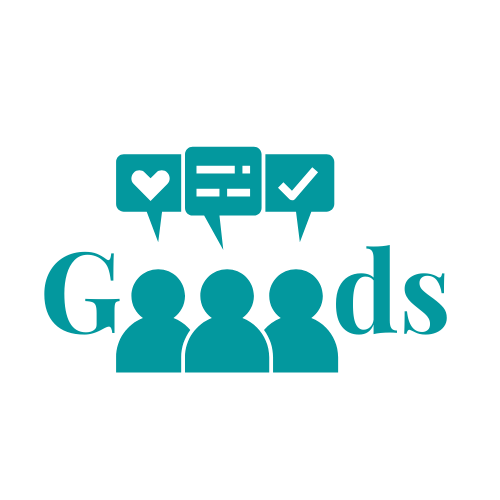


Developed by the following authors: 

 _Ainhoa Rodrigo Bolea (ainhoa2612@gmail.com)_
 
 _Alejandra Lloret Calvo (alejandralloretc@gmail.com)_
 
 _Cristian Fernando Rodríguez Saldarriaga (c.fernandoro@gmail.com)_

 _Juan Pablo Guerrero Ortiz (jguerror41@gmail.com)_ 
 
 _Laura Débora Fernández Basquero (ldfernandez09@gmail.com)_
 
 _Marta Roig Atienza (martaroigatienza@hotmail.com)_
 
 
Based on the research work: **NLP Deceitful Review Detection on e-Commerce and Social Media (2020)**

This work is part of the final master thesis to the _Master of Big Data and Business Analytics of the University Complutense of Madrid. 2019 - 2020._
